In [2]:
!pip install -Uqq --upgrade fastai
from fastai.vision.all import *

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kornia 0.5.5 requires numpy<=1.19, but you have numpy 1.19.5 which is incompatible.
allennlp 2.5.0 requires torch<1.9.0,>=1.6.0, but you have torch 1.9.0 which is incompatible.
allennlp 2.5.0 requires torchvision<0.10.0,>=0.8.1, but you have torchvision 0.10.0 which is incompatible.


In [3]:
import fastai
fastai.__version__

'2.5.1'

In [4]:
dfx = pd.read_csv('../input/wandbcassava/wandb_cassava_train_val_split.csv')
dfx.head()

,image_id,label,is_val
0,1000015157.jpg,0,False
1,1000201771.jpg,3,False
2,100042118.jpg,1,False
3,1000723321.jpg,1,False
4,1000812911.jpg,3,False


In [5]:
dfx.shape

(21397, 3)

In [6]:
dfx.label.value_counts(normalize=True)

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

In [7]:
image_file_paths = ('../input/cassava-leaf-disease-classification/train_images/')
image_file_paths

'../input/cassava-leaf-disease-classification/train_images/'

In [8]:
dfx['image_id'] = dfx['image_id'].map(lambda x: os.path.join(image_file_paths, x))
dfx

,image_id,label,is_val
0,../input/cassava-leaf-disease-classification/train_images/1000015157.jpg,0,False
1,../input/cassava-leaf-disease-classification/train_images/1000201771.jpg,3,False
2,../input/cassava-leaf-disease-classification/train_images/100042118.jpg,1,False
3,../input/cassava-leaf-disease-classification/train_images/1000723321.jpg,1,False
4,../input/cassava-leaf-disease-classification/train_images/1000812911.jpg,3,False
...,...,...,...
21392,../input/cassava-leaf-disease-classification/train_images/999068805.jpg,3,True
21393,../input/cassava-leaf-disease-classification/train_images/999329392.jpg,3,True
21394,../input/cassava-leaf-disease-classification/train_images/999474432.jpg,1,True
21395,../input/cassava-leaf-disease-classification/train_images/999616605.jpg,4,True


In [9]:
def get_x(r): return r['image_id']
def get_y(r): return r['label']

def splitter(df):
    train = df.index[~df['is_val']].tolist()
    valid = df.index[df['is_val']].tolist()
    return train,valid

## Augmentation

In [10]:
import albumentations
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(sz): return albumentations.Compose([
            albumentations.RandomResizedCrop(sz,sz),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(sz): return albumentations.Compose([
    albumentations.CenterCrop(sz,sz, p=1.),
    albumentations.Resize(sz,sz)
], p=1.)

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


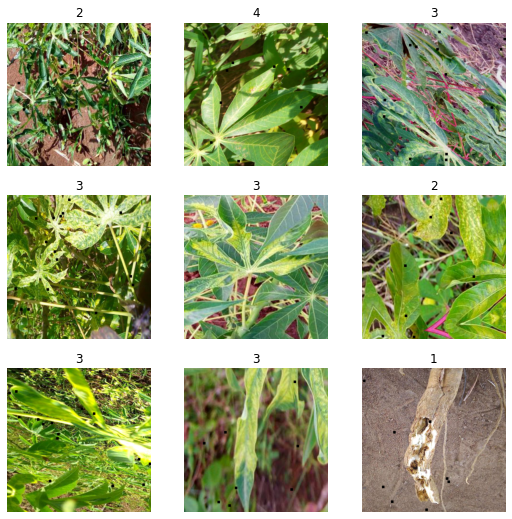

In [11]:
def get_dls(sz, bs=32):
    item_tfms = AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    cassava =  DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_x = get_x,
    get_y = get_y,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms = batch_tfms
    )

    dls = cassava.dataloaders(dfx, bs=bs)
    return dls
dls = get_dls(sz=448, bs=16)
dls.show_batch()

In [12]:
dls.train.dataset, dls.valid.dataset

((#17118) [(PILImage mode=RGB size=800x600, TensorCategory(0)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(1)),(PILImage mode=RGB size=800x600, TensorCategory(1)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(2)),(PILImage mode=RGB size=800x600, TensorCategory(0)),(PILImage mode=RGB size=800x600, TensorCategory(4)),(PILImage mode=RGB size=800x600, TensorCategory(3))...],
 (#4279) [(PILImage mode=RGB size=800x600, TensorCategory(1)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(4)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(4)),(PILImage mode=RGB size=800x600, Tenso

In [13]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
#  opt_func=ranger, loss_func=LabelSmoothingCrossEntropy()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003311311302240938)

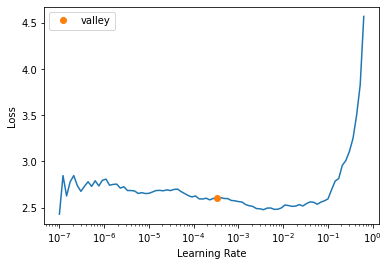

In [14]:
learn.lr_find()

In [15]:
learn.freeze()
mixup = MixUp(alpha=0.4)
es=EarlyStoppingCallback(monitor='accuracy', min_delta=0.1, patience=3)
learn.fit_one_cycle(15, lr_max=1e-3, cbs=[mixup, es])

epoch,train_loss,valid_loss,accuracy,time
0,1.487099,0.907460,0.690348,08:15
1,1.073907,0.571641,0.797383,07:29
2,0.799542,0.505710,0.820051,07:25
3,0.751533,0.435159,0.851133,07:43
4,0.787054,0.421738,0.860715,07:51


No improvement since epoch 1: early stopping


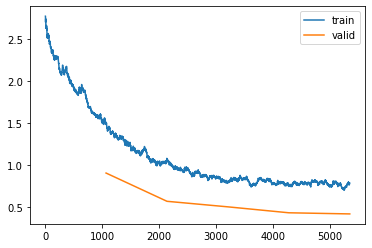

In [16]:
learn.recorder.plot_loss()

In [17]:
preds = learn.tta()

In [18]:
accuracy(*preds)

TensorBase(0.8668)

In [19]:
learn.unfreeze()

SuggestedLRs(valley=6.30957365501672e-05)

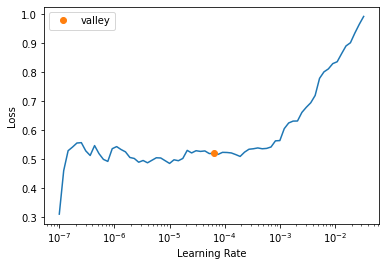

In [20]:
learn.lr_find()

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


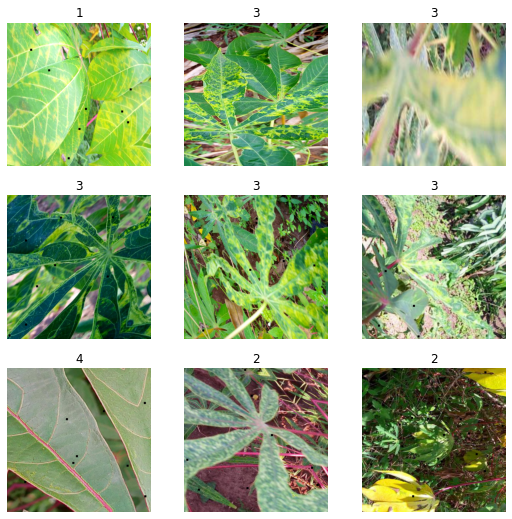

In [21]:
dls = get_dls(sz=560, bs=16)
dls.show_batch()

In [22]:
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4), cbs=[mixup, es])

epoch,train_loss,valid_loss,accuracy,time
0,0.739846,0.404380,0.867025,08:25
1,0.748979,0.382168,0.873802,08:27
2,0.686231,0.375382,0.877308,08:29
3,0.702894,0.370001,0.875438,08:19


No improvement since epoch 0: early stopping


In [23]:
learn.save("stage2-560")

Path('models/stage2-560.pth')

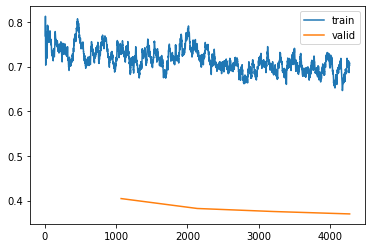

In [24]:
learn.recorder.plot_loss()

In [25]:
tta_preds = learn.tta()

In [26]:
accuracy(*tta_preds)

TensorBase(0.8792)

In [27]:
learn.unfreeze()

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=3.630780702224001e-05)

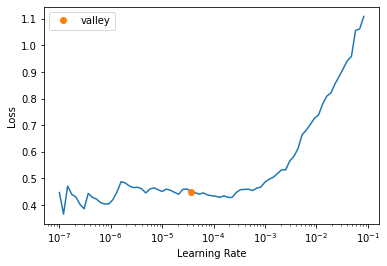

In [28]:
learn.lr_find()

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Could not do one pass in your dataloader, there is something wrong in it


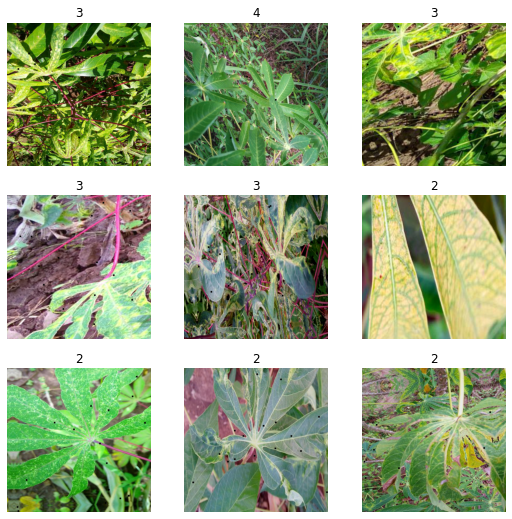

In [29]:
dls = get_dls(sz=720, bs=16)
dls.show_batch()

In [30]:
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4), cbs=[mixup, es])

epoch,train_loss,valid_loss,accuracy,time
0,0.672444,0.373964,0.876139,08:30
1,0.657053,0.367882,0.880112,08:31
2,0.694364,0.359334,0.886889,08:35
3,0.674352,0.360734,0.884319,08:32


No improvement since epoch 0: early stopping


In [32]:
learn.save("stage3-448")

Path('models/stage3-448.pth')

In [33]:
tta_pred = learn.tta()
accuracy(*tta_pred)

TensorBase(0.8867)